In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import linregress

from prosail import run_sail
import gp_emulator

%matplotlib inline

In [6]:
#create inverse transforms

# wrap forward model
def do_FM(albedo, assymetry, lai, rsoil):
    # Go from albeado/assym to reflectance and transmittance
    trans = albedo/(1.0 + assymetry)
    refl = albedo*assymetry/(1.0 + assymetry)
    
    r = np.ones(2101)*refl
    t = np.ones(2101)*trans
    rsoil0 = np.ones(2101)*rsoil
    # Fix following to sensible values
    lidfa = 2
    hspot = 0.01
    # These are sensor angles, - but we will be taking the BHR, which won't be affected by it
    tts=30
    tto=10
    psi=0
    factor = 'BHR'
    bhr = run_sail(r, t, lai, lidfa, hspot, tts, tto, psi, 
                   factor=factor, rsoil0=rsoil0)
    return bhr[0]


In [7]:
# Set up parameter list and min and max params
parameters = ['assymetry', 'albedo', 'lai', 'rsoil']
varmin = [0.001,0.001,0.001,0.001]
varmax = [0.95, 0.95, 10.0, 0.95]

In [8]:
def simulator(x):
    return do_FM(*x[0])

In [58]:
gp, validate, validation_set, validation_gradient, emulated_validation, emulated_gradient = gp_emulator.create_emulator_validation(
    simulator, parameters, varmin, varmax, 500, 1000)

After 5, the minimum cost was -1.697219e+03


(0.99910057578927902, 5.912980831915271e-05, 0.99992704485825235, 0.0, 0.00038204159827522668)
slope      intercept  R          std err   
0.999      0.000      1.000      0.000     


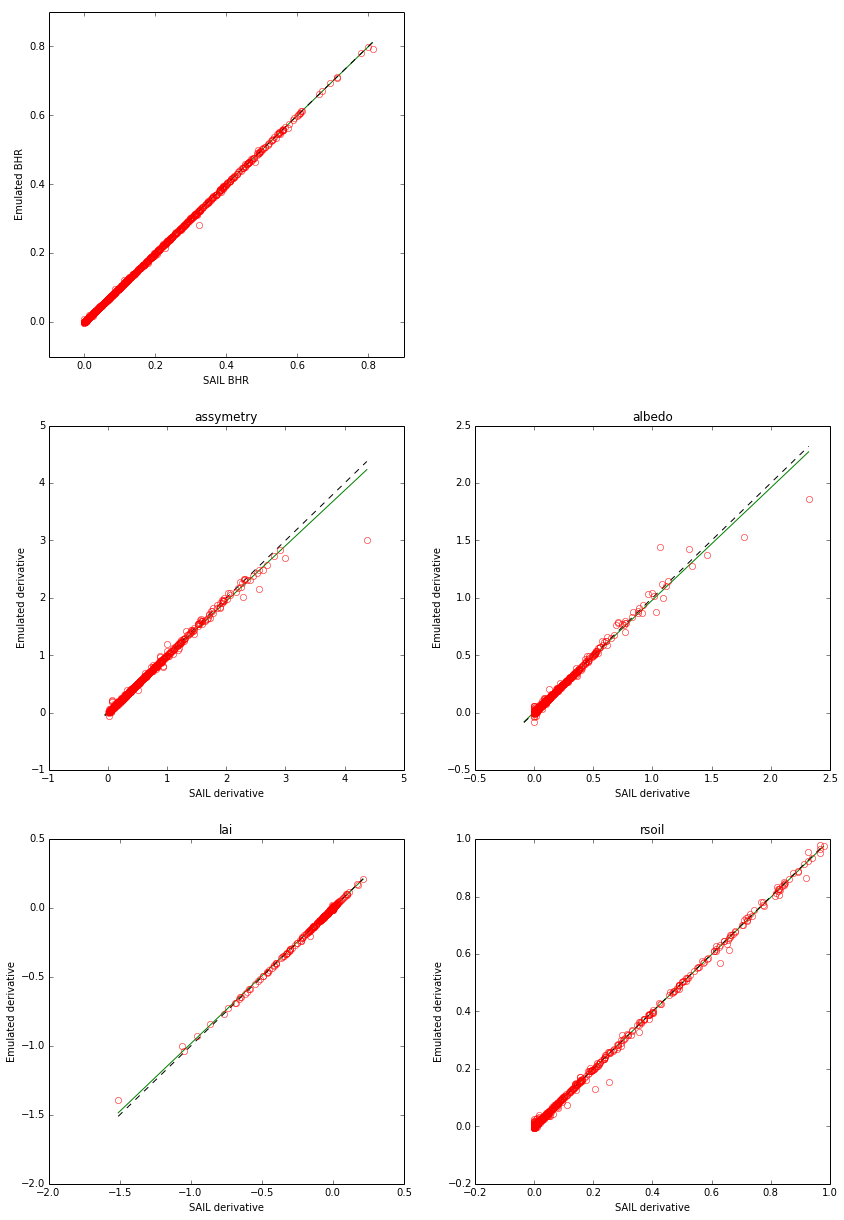

In [57]:
slope, intercept, r_value, p_value, std_err = linregress(
validation_set, emulated_validation.squeeze())
deriv_stats = linregress(validation_set, emulated_validation.squeeze())
print deriv_stats

#print "%6.3f & %6.3f & %6.3f & %6.3e \\\\" % (slope, intercept, r_value, std_err),
print("{:10} {:10} {:10} {:10}".format('slope', 'intercept', 'R', 'std err'))
print("{:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}".format(slope, intercept, r_value, std_err))

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,21))
axs = axs.flatten()


def validation_scatter_plot(axes, original, emulation, labels=['Original', 'Emulated']):
    max_x = np.max((original.max(), emulation.max(), 0.0))
    min_x = np.min((original.min(), emulation.min(), 0.0))
    p = np.polyfit(original, emulation, 1)
    x = np.linspace(min_x, max_x, 5)
    axes.plot(x, np.polyval(p, x), '-g')
    axes.plot([min_x, max_x], [min_x, max_x], 'k--')
    axes.plot(original, emulation, 'o', mfc='none', mec='r')
    axes.set_xlabel(labels[0])
    axes.set_ylabel(labels[1])
'''    
for i in xrange(4):
    print i
    print np.max((validation_gradient[:,i].max(), emulated_gradient[:,i].max()))
    print np.min((validation_gradient[:,i].min(), emulated_gradient[:,i].min()))
#max_test = np.max(validation_gradient[:,i].max(), emulated_gradient[:,i].max())
'''

validation_scatter_plot(axs[0], validation_set, emulated_validation, ['SAIL BHR', 'Emulated BHR'])
axs[1].axis('off')
for i in xrange(4):
    labels = ['SAIL derivative', 'Emulated derivative']
    validation_scatter_plot(axs[i+2], validation_gradient[:,i], emulated_gradient[:,i], labels)
    axs[i+2].set_title(parameters[i])
    #print(emulated_gradient[:,i])



# This was to do the gp without using create_emulator_validation

In [6]:
#create training set
training_set, distributions = gp_emulator.create_training_set(
    parameters, varmin, varmax, n_train = 100)

In [7]:
#Checking things cell:
print(training_set.shape)
tmp = distributions[0]


(100, 4)


In [8]:
#run the FM for each training set
bhr_training = np.array([do_FM(*x) for x in training_set])
#bhr_training = np.array(bhr_training)
print bhr_training
print(bhr_training.shape)

[  1.34125046e-01   1.97771374e-02   2.94721963e-02   9.66768984e-02
   2.73676291e-01   9.30176723e-02   2.81628356e-02   4.18618835e-02
   4.15423215e-01   1.09566747e-01   1.26326770e-01   1.53984214e-02
   1.84661186e-01   2.79429181e-01   1.39775826e-01   4.93284272e-02
   2.22270364e-02   3.17020830e-01   4.31729479e-01   2.71729091e-02
   4.98356802e-01   4.46031585e-01   2.20762495e-01   3.57544633e-01
   9.45838863e-02   3.59336204e-01   9.73529722e-02   3.87138996e-02
   1.83635622e-01   8.11256016e-02   6.71800473e-04   3.32063774e-03
   1.00826615e-01   5.61498143e-02   2.71620988e-01   1.74105970e-01
   1.80383813e-03   4.82082383e-01   3.27018575e-02   4.27034024e-02
   6.44656080e-02   1.13976998e-01   4.95792429e-01   1.47674911e-01
   1.26648477e-01   1.20108650e-02   3.52133807e-01   3.44286988e-02
   2.37156799e-01   1.09831497e-01   2.10144114e-01   1.07125278e-01
   4.19424700e-01   6.42328755e-02   1.16857250e-01   2.26517849e-01
   3.86990610e-01   9.95063762e-03

In [9]:
#create the emulator
gp = gp_emulator.GaussianProcess(training_set, bhr_training)
gp.learn_hyperparameters(n_tries = 5)

After 5, the minimum cost was -2.484794e+02


(-248.47937240346812,
 array([  1.24833648,  -1.11916461,  -2.56589529, -34.1771215 ,
          0.47200515, -12.99435976]))

In [41]:
gp.basis_functions

array([], shape=(0, 1), dtype=float64)

In [ ]:
#create validation set

In [ ]:
#run FM for each validation set

In [ ]:
#do the validation using gp predict